# Tutorial 02: commonroad-io Interface

The collision checker library provides a convenient interface to *commonroad-io*. In order to illustrate the functionality, we load a CommonRoad scenario.


/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 1 cannot be matched!
  warnings.warn("State at time step {} cannot be matched!".format(read_time(xml_node.find('time'))))
/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 2 cannot be matched!
  warnings.warn("State at time step {} cannot be matched!".format(read_time(xml_node.find('time'))))
/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 3 cannot be matched!
  warnings.warn("State at time step {} cannot be matched!".format(read_time(xml_node.find('time'))))
/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 4 cannot be matched!
  warnings.wa

 Text(16.0, 0.0, ''),

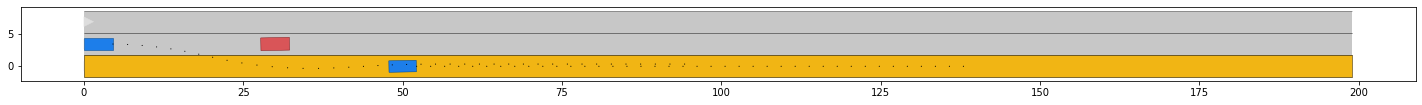

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

# load the exemplary CommonRoad scenario using the CommonRoad file reader
scenario, planning_problem_set = CommonRoadFileReader('ZAM_Tutorial-1_2_T-1.xml').open()

# plot the scenario
rnd = MPRenderer(figsize=(25, 10))
scenario.draw(rnd)
planning_problem_set.draw(rnd)
rnd.render()

## 1. Converting CommonRoad Objects to Collision Objects

All shapes and obstacles can be converted to collision objects in order to perform intersection tests. Therefore, we need to call the function 'create_collision_object()'. The supported CommonRoad objects are:

    - commonroad.geometry.shape.ShapeGroup
    - commonroad.geometry.shape.Polygon
    - commonroad.geometry.shape.Circle
    - commonroad.geometry.shape.Rectangle
    - commonroad.scenario.obstacle.StaticObstacle
    - commonroad.scenario.obstacle.DynamicObstacle
    - commonroad.prediction.prediction.SetBasedPrediction
    - commonroad.prediction.prediction.TrajectoryPrediction
    
Note that the trajectories of dynamic obstacles are not interpolated. So collisions are only considered at discrete points in time.

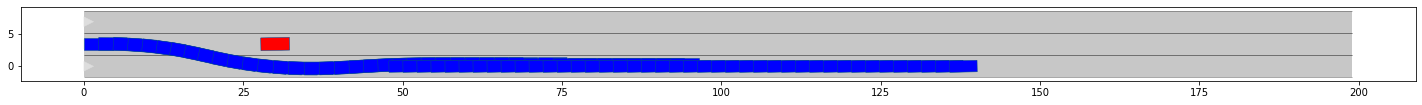

In [2]:
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_object

rnd = MPRenderer(figsize=(25, 10))
scenario.lanelet_network.draw(rnd)

# convert each static obstacle in the scenario to a collision object and plot it
for obs in scenario.static_obstacles:
    rnd.draw_params.shape.facecolor = "red"
    create_collision_object(obs).draw(rnd)

# convert each dynamic obstacle in the scenario to a collision object and plot it
for obs in scenario.dynamic_obstacles:
    rnd.draw_params.shape.facecolor = "blue"
    create_collision_object(obs).draw(rnd)

rnd.render()

## 2. Creating a Collision Checker from the Scenario

A pycrcc.CollisionChecker object can be directly generated from a CommonRoad scenario:

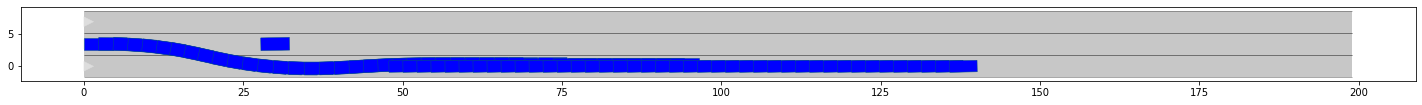

In [3]:
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker

cc = create_collision_checker(scenario)

rnd = MPRenderer(figsize=(25, 10))
scenario.lanelet_network.draw(rnd)
rnd.draw_params.shape.facecolor = "blue"
cc.draw(rnd)
rnd.render()

Given the collision checker for the scenario, it can be easily checked if a trajectory of a ego vehicle collides with an object in the environment.

Collision between the trajectory of the ego vehicle and objects in the environment:  False


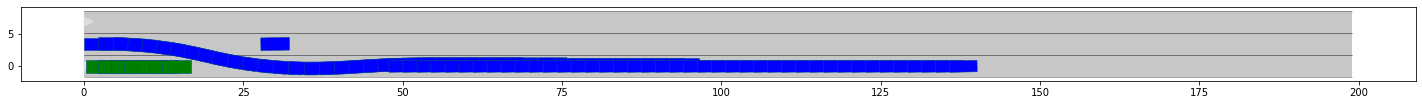

In [4]:
import numpy as np
from commonroad.scenario.trajectory import Trajectory
from commonroad.scenario.state import CustomState
from commonroad.prediction.prediction import TrajectoryPrediction
from commonroad.geometry.shape import Rectangle

# create a trajectory for the ego vehicle starting at time step 0
position = np.array([[2.5, 0.0], [4.5, 0.0], [6.5, 0.0], [8.5, 0.0], [10.5, 0.0], [12.5, 0.0], [14.5, 0.0]])
state_list = list()
for k in range(0, len(position)):
    state_list.append(CustomState(**{'time_step':k,'position': position[k], 'orientation': 0.0}))
trajectory = Trajectory(0, state_list)

# create the shape of the ego vehicle
shape = Rectangle(length=4.5, width=2.0)
# create a TrajectoryPrediction object consisting of the trajectory and the shape of the ego vehicle
traj_pred = TrajectoryPrediction(trajectory=trajectory, shape=shape)

# create a collision object using the trajectory prediction of the ego vehicle
co = create_collision_object(traj_pred)

# test the trajectory of the ego vehicle for collisions
print('Collision between the trajectory of the ego vehicle and objects in the environment: ', cc.collide(co))

rnd = MPRenderer(figsize=(25, 10))
scenario.lanelet_network.draw(rnd)
rnd.draw_params.shape.facecolor = "blue"
cc.draw(rnd)
rnd.draw_params.shape.facecolor = "green"
co.draw(rnd)
rnd.render()

## 3. Minkowski Sum 

The *commonroad-io* interface offers the possibility to compute the minkowski sum with a circle and an arbitrary *commonroad-io* shape before adding the shape to the collision checker.

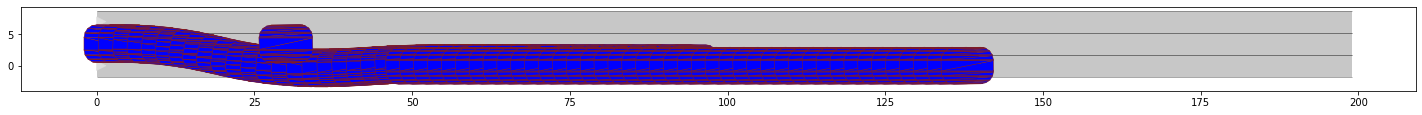

In [5]:
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker

cc = create_collision_checker(scenario, params={'minkowski_sum_circle': True, 
                                                'minkowski_sum_circle_radius': 2.0,
                                                'resolution': 4,
                                                'triangulation_method':'gpc'})

rnd = MPRenderer(figsize=(25, 10))
scenario.lanelet_network.draw(rnd)
rnd.draw_params.shape.facecolor = "blue"
rnd.draw_params.shape.edgecolor = "#831d20"
rnd.draw_params.shape.draw_mesh = True
cc.draw(rnd)
rnd.render()